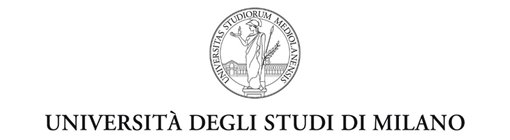

facoltà di Scienze Politiche, Economiche e Sociali
Experimental projects of machin learning(2022- 2023)

# Topic: cats and dog (Project 2)
 
Writer: Elaheh Esfandi

Use Tensorflow 2 to train a neural network for the binary classification of cats and dogs based on images from the given dataset.

### step 0:installing the packages we need

In [ ]:
pip uninstall keras-preprocessing -y

Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [ ]:
pip install -q -U git+https://github.com/keras-team/keras-preprocessing.git

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 13.3 MB/s 
     |████████████████████████████████| 1.6 MB 67.3 MB/s 


### step 1: libraries and datasets


##### step1.1:importing datasets and the libraries


In [ ]:
from zipfile import ZipFile
import keras_tuner as kt
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
from PIL import Image
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
from os.path import isfile,join, exists
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import statistics as st
from PIL import Image

In [ ]:
# upload the data set in to my google colab
!wget https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download \
      -P /image/

--2022-12-22 07:49:08--  https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download
Resolving unimibox.unimi.it (unimibox.unimi.it)... 159.149.53.190
Connecting to unimibox.unimi.it (unimibox.unimi.it)|159.149.53.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/image/download’

download                [     <=>            ] 812.79M   447KB/s    in 7m 55s  

2022-12-22 07:57:04 (1.71 MB/s) - ‘/image/download’ saved [852272294]



In [ ]:
# then i Open the zip file containing all the images
# opening the zip file in read mode
with ZipFile('/image/download', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir() 
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
CatsDogs/Dogs/550.jpg                          2020-03-12 04:37:20         5025
CatsDogs/Dogs/5500.jpg                         2020-03-12 04:37:20        47720
CatsDogs/Dogs/5501.jpg                         2020-03-12 04:37:20        32563
CatsDogs/Dogs/5502.jpg                         2020-03-12 04:37:20        25359
CatsDogs/Dogs/5503.jpg                         2020-03-12 04:37:20        22546
CatsDogs/Dogs/5504.jpg                         2020-03-12 04:37:20         8001
CatsDogs/Dogs/5505.jpg                         2020-03-12 04:37:20        27650
CatsDogs/Dogs/5506.jpg                         2020-03-12 04:37:20        46787
CatsDogs/Dogs/5507.jpg                         2020-03-12 04:37:20        20494
CatsDogs/Dogs/5508.jpg                         2020-03-12 04:37:20        21131
CatsDogs/Dogs/5509.jpg                         2020-03-12 04:37:20        25844
CatsDogs/Dogs/551.jpg                          2020-03-12 04:37:20   

##### step1.2: data preparation 

In [ ]:
# Define the paths,the glob module is used to retrieve files/pathnames matching a specified pattern.
#to retrieve paths recursively from inside the directories/files and subdirectories/subfiles.
cat_path = glob.glob("./../content/CatsDogs/Cats/*****.jpg")
dog_path = glob.glob("./../content/CatsDogs/Dogs/*****.jpg")
paths = [cat_path, dog_path]

In [ ]:
# Remove the images w/ size = 0
for path in paths:
  for filename in path:  
    if os.stat(filename).st_size==0:
      os.remove(filename)
      num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        fobj = open(filename, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(filename)

print("Deleted %d images" % num_skipped)

Deleted 1588 images


In [ ]:
df_cat = pd.DataFrame({"file_name": [f"/content/CatsDogs/Cats/{i}" for i in os.listdir('/content/CatsDogs/Cats')]})
df_cat["label"] = "cat"
df_dog = pd.DataFrame({"file_name": [f"/content/CatsDogs/Dogs/{i}" for i in os.listdir('/content/CatsDogs/Dogs')]})
df_dog["label"] = "dog"
all_df = pd.concat([df_cat, df_dog], ignore_index=True)
all_df = all_df.sample(frac=1, random_state = 666).reset_index(drop=True)
all_df

,file_name,label
0,/content/CatsDogs/Cats/8468.jpg,cat
1,/content/CatsDogs/Dogs/3054.jpg,dog
2,/content/CatsDogs/Dogs/4422.jpg,dog
3,/content/CatsDogs/Dogs/338.jpg,dog
4,/content/CatsDogs/Cats/4056.jpg,cat
...,...,...
23405,/content/CatsDogs/Cats/6356.jpg,cat
23406,/content/CatsDogs/Cats/12125.jpg,cat
23407,/content/CatsDogs/Cats/10459.jpg,cat
23408,/content/CatsDogs/Cats/11973.jpg,cat


In [ ]:
all_df.describe()

,file_name,label
count,23410,23410
unique,23410,2
top,/content/CatsDogs/Cats/8468.jpg,cat
freq,1,11741


In [ ]:
# Split in training, validation set and test set
train_val_df, test_df = train_test_split(all_df, test_size=0.2, random_state = 666)

In [ ]:
# Split training, validation set in training and validation set
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state = 666)

Images must be transformed from JPG to RGB (or grayscale) pixel values and scaled down. Experiment with different network architectures and training parameters documenting their influence of the final predictive performance.

In [ ]:
image_data_generator = ImageDataGenerator(rescale=1/255.0)
validation_imagedatagenerator = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# Flow From DataFrame
train_valid_generator = image_data_generator.flow_from_dataframe(dataframe=train_val_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

test_generator=image_data_generator.flow_from_dataframe(dataframe = test_df, directory=None,
                                                          x_col="file_name", y_col="label",
                                                          batch_size=64, 
                                                          seed=123, shuffle=True, class_mode="binary",
                                                          target_size=(180,180))

train_generator = image_data_generator.flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

valid_generator = image_data_generator.flow_from_dataframe(dataframe= val_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.


###step3:models 

#####model1 :VGG

architecture of VGG:

**input:**VGG takes in a 224x224 pixel RGB image. For the ImageNet competition, the authors cropped out the center 224x224 patch in each image to keep the input image size consistent.

**Convolutional Layers:** The convolutional layers in VGG use a very small receptive field (3x3, the smallest possible size that still captures left/right and up/down). There are also 1x1 convolution filters which act as a linear transformation of the input, which is followed by a ReLU unit. The convolution stride is fixed to 1 pixel so that the spatial resolution is preserved after convolution.

**Fully-Connected Layers:** VGG has three fully-connected layers: the first two have 4096 channels each and the third has 1000 channels, 1 for each class.

**Hidden Layers:** All of VGG’s hidden layers use ReLU (a huge innovation from AlexNet that cut training time). VGG does not generally use Local Response Normalization (LRN), as LRN increases memory consumption and training time with no particular increase in accuracy.

In [ ]:
# Model 1 Specification
def model_1_specification():
    inputs = keras.Input(shape = (180,180,3))
    
    # First block w/ 32 filters
    x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    
    # Fully Connected Layers
    x = layers.Dense(128, activation = "relu")(x)   
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

Before we can start with training, we have to compile the model using the compile method. Compiling configures the model for training.
I choose the "Adam" optimizer as this is an excellent default to start with. The loss function is "binary_cross_entropy" because we are training a classification model with two possible outputs. I want to report the accuracy during training; therefore, I added accuracy as a metric.

In [ ]:
# Compile
model = model_1_specification()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0     

After i compiled the model, i started training the model by calling the fit method on the model instance. the parameters are as bellow:


1. **The first parameter** is the iterator that we created by calling the flow_from_directory of the ImageDataGenerator for the training data. 
2. **The second parameter** is the iterator from the validation data.
3. **The epoch parameter** shows how many times the model will process the entire training set. Here, I want to process all 20.000 training images 50 times.
4. **The steps_per_epoch** show how many batches it should process before it finishes the epoch. i established a batch size of 200 previously on the flow_from_directory, which gives 200 * 50 = 20,000 — the number of images of our training set. The same goes for the validation_steps, 50 * 100 = 5,000, the number of images in our validation set.



In [ ]:
# Fiting the model
step_size_train = train_valid_generator.n//train_valid_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator= train_valid_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=test_generator,
                    epochs=2,
                    validation_steps=step_size_validation
                    )

<ipython-input-17-4b1630a8b769>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator= train_valid_generator,


Epoch 1/2
292/292 [==============================] - 1015s 3s/step - loss: 0.6456 - accuracy: 0.6719 - val_loss: 0.5439 - val_accuracy: 0.7312
Epoch 2/2
292/292 [==============================] - 984s 3s/step - loss: 0.4801 - accuracy: 0.7701 - val_loss: 0.5154 - val_accuracy: 0.7558


In [ ]:
features = model.predict(test_generator)

74/74 [==============================] - 71s 959ms/step


In [ ]:
features

array([[0.00043573],
       [0.23728253],
       [0.22302401],
       ...,
       [0.28452888],
       [0.43290308],
       [0.05659547]], dtype=float32)

In [ ]:
features = model.predict(test_generator)

Text(0.5, 1.0, 'Model 1: Training vs Test Accuracy')

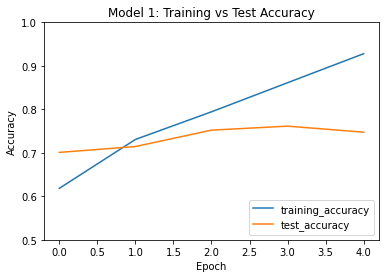

In [ ]:
# plot the model
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model : Training vs Test Loss')

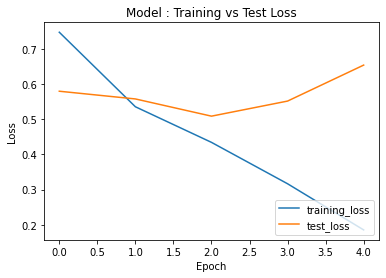

In [ ]:
# plot the model
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model : Training vs Test Loss")

In [ ]:
# validation
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 64s 856ms/step - loss: 0.6556 - accuracy: 0.7471
Test Loss: 0.6556402444839478
Test Accuracy: 0.7471166253089905


#####model2 : Hyperparameter tuning

Parameters of the model are the parameters calculated on the given dataset by the model. The weights of a deep neural network, for instance.

**Hyperparameters of Models:** are the parameters where the data model cannot predict. This is used for calculating the parameters of the model, in deep neural networks is the learning rate.

In [ ]:
# Define a HyperModel class
def build_hypermodel(hp):
    inputs = keras.Input(shape = (180,180,3))
    
    data_augmentation = hp.Float("data_augmentation", min_value = 0.01, max_value = 0.1, step = 0.01)
    dropout_hidden_layer = hp.Float("dropout_hidden_layer", min_value = 0.05, max_value = 0.1, step = 0.01)
    dropout_flatten_layer = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)


    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(data_augmentation)(x)
    x = layers.RandomZoom(data_augmentation)(x)

    # First block w/ 32 filters
    x = layers.Conv2D(filters = hp.Int("convolution_1_filters", min_value = 16, max_value = 64, step = 16), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = hp.Int("convolution_2_filters", min_value = 64, max_value = 128, step = 32), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Third block w/ 128 filters
    x = layers.Conv2D(filters = hp.Int("convolution_3_filters", min_value = 128, max_value = 256, step = 64), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Fourth block w/ 256 filters
    x = layers.Conv2D(filters = hp.Int("convolution_4_filters", min_value = 256, max_value = 512, step=128), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)

    x = layers.Dropout(dropout_flatten_layer)(x)

    # First Fully Connected Layers    
    x = layers.Dense(hp.Int("num_units", min_value = 64, max_value = 256, step = 64), activation = "relu")(x) 

    # Second Fully Connected Layers    
    x = layers.Dropout(dropout_flatten_layer)(x)
    x = layers.Dense(hp.Int("num_units_second_layer", min_value = 64, max_value = 256, step=64), activation="relu")(x)

    # Last Fully Connected Layer
    x = layers.Dropout(dropout_flatten_layer)(x)  
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model.summary()

 The tuning technique is used to estimate the best hyperparameter combination that helps the algorithm to optimise the efficiency of the model. 
 acording to the Methods of Hyper-Parameter Tuning, **bayesian Optimization** is The optimisation challenge is to tune and locate the correct hyperparameters for your model. By adjusting model parameters, to minimise the loss function of our model. In a minimal number of moves, Bayesian optimism helps one find the minimum point. Bayesian optimization also uses a buying feature which guides the sampling in areas where the best observation is likely to improve on the present one.

In [ ]:
# Tuner
tuner = kt.BayesianOptimization(build_hypermodel, objective="val_accuracy", max_trials=3, 
                                directory="cats_dogs_run",
                                project_name="cats_dogs_classification",
                                overwrite=False)

In [ ]:
# Summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
data_augmentation (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': 0.01, 'sampling': None}
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.1, 'step': 0.01, 'sampling': None}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
convolution_4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
num_units (Int)
{'default': None, '

In [ ]:
# Stop the training when you start overfitting
stop_early = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]

In [ ]:
# Start the search! 
tuner.search(train_generator, 
             batch_size=64, 
             epochs=2, 
             validation_data=valid_generator
             ,callbacks = stop_early)

Trial 3 Complete [01h 11m 46s]
val_accuracy: 0.686065137386322

Best val_accuracy So Far: 0.6882007718086243
Total elapsed time: 03h 29m 22s


In [ ]:
# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=3)[0]

In [ ]:
best_hyperparameters.values

{'data_augmentation': 0.05,
 'dropout_hidden_layer': 0.05,
 'dropout_flatten_layer': 0.30000000000000004,
 'convolution_1_filters': 48,
 'convolution_2_filters': 64,
 'convolution_3_filters': 192,
 'convolution_4_filters': 384,
 'num_units': 256,
 'num_units_second_layer': 192}

In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Train the model on the training set for 2 epochs
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
history = hypermodel.fit(train_generator, epochs=2, validation_data = valid_generator, callbacks = stop_early)

# Get the best hepoch, i.e. the epoch with highest validation accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/2
235/235 [==============================] - 1992s 8s/step - loss: 0.7500 - accuracy: 0.5295 - val_loss: 0.6746 - val_accuracy: 0.5937
Epoch 2/2
235/235 [==============================] - 1982s 8s/step - loss: 0.6422 - accuracy: 0.6491 - val_loss: 0.5535 - val_accuracy: 0.7077
Best epoch: 2


In [ ]:
# Re-instantiate the model w/ optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Retrain the model on the optimal number of epochs
history = hypermodel.fit(train_valid_generator, epochs = int(best_epoch*1.2), validation_data = test_generator)


Epoch 1/2
293/293 [==============================] - 2489s 8s/step - loss: 0.7047 - accuracy: 0.5659 - val_loss: 0.6082 - val_accuracy: 0.6824
Epoch 2/2
293/293 [==============================] - 2481s 8s/step - loss: 0.6026 - accuracy: 0.6806 - val_loss: 0.5068 - val_accuracy: 0.7471


In [ ]:
hypermodel.summary()

NameError: ignored

Text(0.5, 1.0, 'Training vs Validation Accuracy')

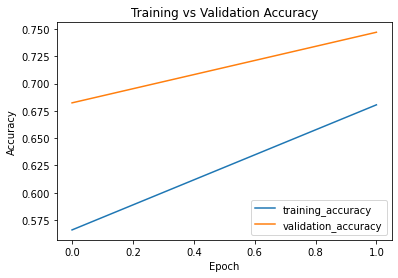

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation Accuracy")

Text(0.5, 1.0, 'Training vs Validation Loss')

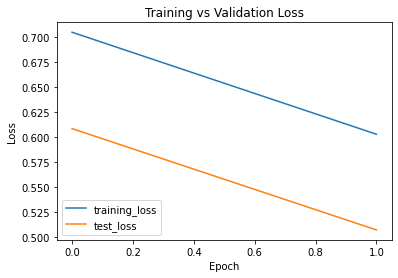

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.title("Training vs Validation Loss")

In [ ]:
test_loss, test_acc = hypermodel.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 151s 2s/step - loss: 0.5068 - accuracy: 0.7471
Test Loss: 0.5067939758300781
Test Accuracy: 0.7471166253089905


## step 4: Cross-Validation

Useing 5-fold cross validation to compute the risk estimates. While the training loss can be chosen freely, the reported cross-validated estimates will be computed according to the zero-one loss.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

In [ ]:
# K-fold Cross Validation model evaluation
# Define the K-fold Cross Validator
kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
kf2 = KFold(n_splits = 5, shuffle = True, random_state = 123)
count = 1

# Define per-fold score containers
TEST_ACCURACY = []
TEST_LOSS = []

Now, let's slightly adapt the model in order to add K-fold Cross Validation:

Firstly, we'll strip off some code for the model that we no longer need.

secondly,longer generate the visualizations, and remove the part generating them

In [ ]:
for val_train_index, test_index in kf.split(all_df):
#FIRST SPLIT: train+validation set and test set
    val_train, df_test = all_df.iloc[val_train_index], all_df.iloc[test_index]
    print("\n")
    print("Cross validation split n(1,2,3,4,5)")
    train, validation = next(kf2.split(val_train))
    
#SECOND SPLIT: train set and validation set
    df_train, df_validation = val_train.iloc[train], val_train.iloc[validation]
    print("length of training set" + str(len(train)))
    print("length of validation set " + str(len(validation)))
    print("length of test set" + str(len(test_index)))
 
#data GENERATORS
    train_data_generator = image_data_generator.flow_from_dataframe(df_train, 
                                                   directory = None,
                                                   x_col = "file_name", 
                                                   y_col = "label",
                                                   class_mode = "binary", 
                                                   shuffle = True,
                                                   seed = 666,
                                                   target_size=(180,180), 
                                                  batch_size = 64)
    valid_data_generator  = image_data_generator.flow_from_dataframe(df_validation, 
                                                    directory = None, 
                                                    x_col = "file_name",
                                                    y_col = "label",
                                                    class_mode = "binary", 
                                                    shuffle = True,
                                                    seed = 666,
                                                    target_size=(180,180),
                                                   batch_size = 64)
    test_data_generator = image_data_generator.flow_from_dataframe(df_test, 
                                                  directory = None, 
                                                  seed = 666,
                                                  x_col = "file_name",
                                                  y_col = "label",
                                                  class_mode = "binary", 
                                                  shuffle = True, 
                                                  target_size=(180,180),
                                                  batch_size = 64)
    
# model
    model=model_1_specification()
    model.compile(loss='binary_crossentropy',optimizer="rmsprop", metrics=['accuracy'])    
       
# Fiting the model
    history = model.fit(train_data_generator,
                    validation_data = valid_data_generator,
                    steps_per_epoch = train_data_generator.n//train_data_generator.batch_size,
                    validation_steps = valid_data_generator.n//valid_data_generator.batch_size,
                    epochs = 2)
 # Provide scores   
    print("results evalution:")
    results = model.evaluate(test_data_generator)
    print(results)
    tf.keras.backend.clear_session()



Cross validation split n(1,2,3,4,5)
length of training set14982
length of validation set 3746
length of test set4682
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/2
234/234 [==============================] - 565s 2s/step - loss: 0.8669 - accuracy: 0.6323 - val_loss: 0.5666 - val_accuracy: 0.7004
Epoch 2/2
234/234 [==============================] - 561s 2s/step - loss: 0.5356 - accuracy: 0.7425 - val_loss: 0.4797 - val_accuracy: 0.7780
results evalution:
74/74 [==============================] - 51s 691ms/step - loss: 0.4802 - accuracy: 0.7713
[0.4801616072654724, 0.7712516188621521]


Cross validation split n(1,2,3,4,5)
length of training set14982
length of validation set 3746
length of test set4682
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated 